# Apply Keras Networks to V1 Data

**Ted Moskovitz, 2018**

load dependencies, set display parameters

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio 
import h5py
from v1_data import V1
import os
import os.path
from time import time
import nonlinearity as nl

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, GRU, CuDNNLSTM, Flatten, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import Input
from keras.models import Model
from keras.optimizers import RMSprop, SGD, Adam
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping, TensorBoard
import time 

from tf_utils import neglogli, poiss_full, get_bps, r2, restore_performance_checkpt, color, get_nn_model
from nn_models import gen_fc_model, gen_rnn_model, gen_cnn_model, gen_ES_model

# set plots inside notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 18

N_COMPLEX = len(os.listdir('./RustV1/complex/data/'))
N_SIMPLE = len(os.listdir('./RustV1/simple/data/'))
N_EXTRA = len(os.listdir('./RustV1/simple/extra/'))
cell_nums = {'simple':N_SIMPLE, 'complex':N_COMPLEX, 'extra':N_EXTRA}

**Standard DNN Models**

In [5]:
ln_fs = [0,1,2,3,4,5]

h_layers_fc = [0,1,2,3]
h_sizes_fc = [1,2,3,4,5,16,32,64,128]

h_layers_rnn = [0,1,2]
h_sizes_rnn = [2,5,10,25,50]

h_layers_cnn = [0,1,2,3]
h_sizes_cnn = [2,4,8,16,32,64]

# dictionary of hyperparameters
hparams = {'fc':{'h_layers':h_layers_fc, 'h_sizes':h_sizes_fc, 'ndepths':len(h_layers_fc), 'nwidths':len(h_sizes_fc)},
          'rnn':{'h_layers':h_layers_rnn, 'h_sizes':h_sizes_rnn, 'ndepths':len(h_layers_rnn), 'nwidths':len(h_sizes_rnn)},
          'cnn':{'h_layers':h_layers_cnn, 'h_sizes':h_sizes_cnn, 'ndepths':len(h_layers_cnn), 'nwidths':len(h_sizes_cnn)}}

training pipeline

In [12]:
# model settings
celltype = 'simple'
model_type = 'cnn'
plot = False 
gen_psth = False
save_model = False
save_perf = False 
restore_frm_chkpt = False
save_best = True
extra = True # only for simple
v1 = V1(celltype, 1, extra=extra)

ndepths = hparams[model_type]['ndepths']
nwidths = hparams[model_type]['nwidths']
nfilts = len(ln_fs)

performance_bps = np.zeros([ndepths, nwidths, cell_nums[celltype]])
performance_r2 = np.zeros([ndepths, nwidths, cell_nums[celltype]])
filter_bps = np.zeros([nfilts])
filter_r2 = np.zeros([nfilts])
best_r2 = -1.
best_bps = -1.

# can choose to restore performance checkpoint
if restore_frm_chkpt:
    print (color.BOLD + 'loading checkpoint...' + color.END)
    performance_bps = restore_performance_checkpt('./SavedResults/' + celltype \
                                                  + '_' + model_type + '_bps.csv')
    performance_bps = performance_bps.reshape(ndepths, nwidths, cell_nums[celltype])
    best_bps = np.max(performance_bps)
    
    performance_r2 = restore_performance_checkpt('./SavedResults/' + celltype \
                                                 + '_' + model_type + '_r2.csv')
    performance_r2 = performance_r2.reshape(ndepths, nwidths, cell_nums[celltype])
    best_r2 = np.max(performance_r2)
    

# define early stopping callback - UNUSED currently
earlystop = EarlyStopping(monitor='val_loss', patience=3, min_delta=.1, verbose=1, mode='auto')
callbacks_list = [earlystop]

# model type
gen_model = {'fc':gen_fc_model, 'rnn':gen_rnn_model, 'cnn':gen_cnn_model}

# data format
if model_type in ['rnn', 'cnn']: flatten = False;
else: flatten = True;
    
perfs = np.zeros(cell_nums[celltype])


k = 0
for cell_num in range(3,6): #cell_nums[celltype]
    v1 = V1(celltype, cell_num+1, flatten=flatten, extra=True, gen_rpts=not extra);
    i = 0
    for L in [2]:#hparams[model_type]['h_layers']:
        j = 0
        for H in [64]:#hparams[model_type]['h_sizes']:
            if performance_bps[i,j,k] == 0.: # avoid redundancy
                print ("============================================================")
                print (color.BOLD + "Training Model on Cell " + str(cell_num+1) + " of " + str(cell_nums[celltype])  \
                       + " with depth of " + str(L+2) + " and width of " + str(H) + color.END) 
                # generate model
                model = gen_model[model_type](H, L=L, dim=v1.X_train.shape[-1])
                #model = get_nn_model(celltype, model_type, metric='r2', filts=False)

                # fit model
                hist = model.fit(v1.X_train, v1.y_train, batch_size=50, epochs=16, 
                                 verbose=1, callbacks=None, validation_data=(v1.X_val, v1.y_val)) #22 for comp
                time.sleep(0.1)

                # evaluate performance
                bps,_ = get_bps(model, v1)
                _, rsq = r2(model.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,))
                
                #perfs[cell_num] = rsq

                if bps > best_bps and save_model:
                    best_bps = bps
                    print (color.PURPLE + 'saving new bps model...' + color.END)
                    model.save('SavedModels/' + celltype + '_best_' + model_type + '_bps.h5')

                if (rsq > best_r2 and save_model) or save_best:
                    best_r2 = rsq
                    print (color.PURPLE + 'saving new r2 model...' + color.END)
                    model.save('SavedModels/'+celltype + '_best_' + model_type + '_r2_cell'
                               + str(cell_num+4)+'.h5')

                performance_bps[i,j,k] = bps
                performance_r2[i,j,k] = rsq

                # generate a PSTH using the current cell's repeat data, if desired
                if gen_psth:
                    rpt_preds = model.predict(v1.X_rpt)
                    model_psth = v1.convert_nn_psth(rpt_preds)

                    if plot:
                        plt.plot(model_psth, label='nn')
                        plt.plot(v1.psth, label='repeat')
                        plt.legend()
                        plt.xlabel('Time (ms)')
                        plt.ylabel('Rate (sp/s)')
                        plt.show()


                print ("bps: ", bps)
                print ("r2: ", rsq)
                print (" ")


            j += 1
            
            if save_perf: 
                print (color.BOLD + 'saving checkpoint...\n' + color.END)
                np.savetxt('./SavedResults/' + celltype + '_' + model_type \
                           + '_bps.csv', performance_bps.reshape(-1,1), delimiter=',')
                np.savetxt('./SavedResults/' + celltype + '_' + model_type \
                           + '_r2.csv', performance_r2.reshape(-1,1), delimiter=',')
        i += 1
    k += 1


building data...
fetching repeat data...
done.
building data...
done.
Training Model on Cell 4 of 3 with depth of 4 and width of 64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 16, 64)            7232      
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 16, 64)            28736     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 8, 64)             0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 8, 64)             20544     
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 8, 64)             20544     
__________

In [35]:
model.save('SavedModels/' + celltype + '_best_' + model_type + '_r2_cell1.h5')

**pca reconstruction experiment**

In [8]:
def get_nn_wts(model, celltype, metric='r2', verbose=False, filts=False):
    nn = get_nn_model(celltype, model, metric=metric, verbose=verbose, filts=filts) 
    if verbose: nn.summary(); 
    weights = [l.get_weights() for l in nn.layers]
    return weights

def get_filts(wts):
    return wts[0][0]

def pca_reconstruct(filts, i):
    n = filts.shape[1]
    X = filts#.reshape(-1,128)
    mu = np.mean(X, axis = 0)
    X_c = X - mu # zero-center the data (important)
    cov = np.dot(X_c.T, X_c) / X.shape[0] # get the data covariance matrix
    U,S,V = np.linalg.svd(cov)
    #Xrot = np.dot(X, U) # decorrelate the data
    Ured = U[:,:i] if i < n else U
    Xrot_red = np.dot(X_c, Ured) # Xrot_reduced becomes [N x i]
    X_rec = np.dot(Ured, Xrot_red.T) + mu.reshape(X.shape[1],1)
    return X_rec.T

def get_upper_wts(wts):
    # extract upper layer weights
    ws = {}
    bs = {}
    lc = 1
    for l in range(len(wts)):
        if len(wts[l]) > 0:
            ws[lc] = wts[l][0]
            bs[lc] = wts[l][1]
            lc += 1
    return ws, bs

In [10]:
mod = get_nn_model('simple', 'cnn', metric='r2', verbose=True, filts=False)
mod.summary()

loading cnn...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_183 (Conv1D)          (None, 16, 64)            7232      
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 16, 64)            28736     
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 8, 64)             0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 8, 64)             20544     
_________________________________________________________________
conv1d_186 (Conv1D)          (None, 8, 64)             20544     
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 4, 64)             0     

In [31]:
ws[0][0].shape

(7, 16, 64)

In [38]:
celltype = 'simple'
model_type = 'cnn'
n_filts_fc = {'simple':64, 'complex':128}
n_filts_cnn = {'simple':64, 'complex':32}
n_filts = {'fc':n_filts_fc, 'cnn':n_filts_cnn}
cell_nums['simple'] = 9
perfs = np.zeros([cell_nums[celltype], n_filts[model_type][celltype]])
metric='r2'
save_perf = True
metric_names = {'r2':'r^2', 'bps':'I_{ss}'}
extra = False

for c in range(1,10):
    print ('===============================')
    print ('Working on Cell {} of {}'.format(c,cell_nums[celltype]))
    cc = c
    if c > 3: 
        extra = True
        cc = c - 3
    v1 = V1(celltype, cc, flatten=True if model_type=='fc' else False, extra=extra, gen_rpts=not extra) 
    mm = get_nn_model(celltype, model_type, metric='r2', verbose=True, filts=False, cell=c) 
    K,b = mm.layers[0].get_weights()

    for i in range(1,n_filts[model_type][celltype]+1):
        # reconstruct filters using principle components
        nf = n_filts[model_type][celltype]
        Kr = K.reshape(-1,nf) if model_type == 'cnn' else K
        K_red = pca_reconstruct(Kr, i)
        K_red = K_red.reshape(K.shape) if model_type != 'fc' else K_red
        # insert reconstructed filters into model
        mm.layers[0].set_weights(weights=[K_red, b])

        # test it
        if metric == 'bps': p,_ = get_bps(mm, v1);
        else: _, p = r2(mm.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,));
        
        perfs[c-1,i-1] = p
        print ("{}/{} reconstructed filter(s): {} = {}".format(i,
                                                               n_filts[model_type][celltype],
                                                               metric_names[metric],
                                                               p))
    

if save_perf:
    path = './SavedResults/{}_{}_pca_{}.csv'.format(celltype, model_type, metric)
    np.savetxt(path, perfs, delimiter=',')


Working on Cell 1 of 9
building data...
fetching repeat data...
done.
loading cnn...
1/64 reconstructed filter(s): r^2 = 0.21569139103129037
2/64 reconstructed filter(s): r^2 = 0.26834499240316895
3/64 reconstructed filter(s): r^2 = 0.2986217127911021
4/64 reconstructed filter(s): r^2 = 0.30410292195402755
5/64 reconstructed filter(s): r^2 = 0.3062184043928375
6/64 reconstructed filter(s): r^2 = 0.3078451022227069
7/64 reconstructed filter(s): r^2 = 0.3097970191058829
8/64 reconstructed filter(s): r^2 = 0.31017871018628096
9/64 reconstructed filter(s): r^2 = 0.31023043682489787
10/64 reconstructed filter(s): r^2 = 0.3104371899986003
11/64 reconstructed filter(s): r^2 = 0.31067503752231296
12/64 reconstructed filter(s): r^2 = 0.31088566130754414
13/64 reconstructed filter(s): r^2 = 0.31095732716462887
14/64 reconstructed filter(s): r^2 = 0.3110495273150974
15/64 reconstructed filter(s): r^2 = 0.3110737776090559
16/64 reconstructed filter(s): r^2 = 0.3111697788601238
17/64 reconstructed 

12/64 reconstructed filter(s): r^2 = 0.14038441446443287
13/64 reconstructed filter(s): r^2 = 0.14144815552706452
14/64 reconstructed filter(s): r^2 = 0.14231639418585829
15/64 reconstructed filter(s): r^2 = 0.1429382758821177
16/64 reconstructed filter(s): r^2 = 0.1433675397428122
17/64 reconstructed filter(s): r^2 = 0.14386374542711006
18/64 reconstructed filter(s): r^2 = 0.14469971383389668
19/64 reconstructed filter(s): r^2 = 0.14531896893878685
20/64 reconstructed filter(s): r^2 = 0.14654185065976602
21/64 reconstructed filter(s): r^2 = 0.14689275231523766
22/64 reconstructed filter(s): r^2 = 0.1478754434494571
23/64 reconstructed filter(s): r^2 = 0.14864160397422874
24/64 reconstructed filter(s): r^2 = 0.14899131170825866
25/64 reconstructed filter(s): r^2 = 0.1491475810599354
26/64 reconstructed filter(s): r^2 = 0.14940482899395807
27/64 reconstructed filter(s): r^2 = 0.15008635975812823
28/64 reconstructed filter(s): r^2 = 0.15008895271157777
29/64 reconstructed filter(s): r^2 

26/64 reconstructed filter(s): r^2 = 0.35117712834361253
27/64 reconstructed filter(s): r^2 = 0.35179321639817634
28/64 reconstructed filter(s): r^2 = 0.3518263606050902
29/64 reconstructed filter(s): r^2 = 0.3517586425200784
30/64 reconstructed filter(s): r^2 = 0.35170305043175115
31/64 reconstructed filter(s): r^2 = 0.35189297057442037
32/64 reconstructed filter(s): r^2 = 0.3520869113106175
33/64 reconstructed filter(s): r^2 = 0.35247585909275525
34/64 reconstructed filter(s): r^2 = 0.35253154809529685
35/64 reconstructed filter(s): r^2 = 0.35241947546520386
36/64 reconstructed filter(s): r^2 = 0.35234548821721434
37/64 reconstructed filter(s): r^2 = 0.3522832313206494
38/64 reconstructed filter(s): r^2 = 0.3525980698899802
39/64 reconstructed filter(s): r^2 = 0.3527782902160479
40/64 reconstructed filter(s): r^2 = 0.35287242028770577
41/64 reconstructed filter(s): r^2 = 0.35277380706183825
42/64 reconstructed filter(s): r^2 = 0.3527887962785591
43/64 reconstructed filter(s): r^2 = 0

40/64 reconstructed filter(s): r^2 = 0.11412133946925188
41/64 reconstructed filter(s): r^2 = 0.11407318575404841
42/64 reconstructed filter(s): r^2 = 0.11405652504235762
43/64 reconstructed filter(s): r^2 = 0.11403572431609865
44/64 reconstructed filter(s): r^2 = 0.11408160048464559
45/64 reconstructed filter(s): r^2 = 0.1141558464777827
46/64 reconstructed filter(s): r^2 = 0.11414955007924958
47/64 reconstructed filter(s): r^2 = 0.11414702130053037
48/64 reconstructed filter(s): r^2 = 0.11415318505021534
49/64 reconstructed filter(s): r^2 = 0.11414622112641179
50/64 reconstructed filter(s): r^2 = 0.114162705064316
51/64 reconstructed filter(s): r^2 = 0.11412549699331771
52/64 reconstructed filter(s): r^2 = 0.11412844156427959
53/64 reconstructed filter(s): r^2 = 0.11413422131864497
54/64 reconstructed filter(s): r^2 = 0.11411832861220299
55/64 reconstructed filter(s): r^2 = 0.11411448185120288
56/64 reconstructed filter(s): r^2 = 0.11408569634065635
57/64 reconstructed filter(s): r^2

54/64 reconstructed filter(s): r^2 = 0.2379094238676248
55/64 reconstructed filter(s): r^2 = 0.23790521143870885
56/64 reconstructed filter(s): r^2 = 0.23791428207106746
57/64 reconstructed filter(s): r^2 = 0.23794366696731187
58/64 reconstructed filter(s): r^2 = 0.23795793926242703
59/64 reconstructed filter(s): r^2 = 0.23798951918753228
60/64 reconstructed filter(s): r^2 = 0.2379900757332013
61/64 reconstructed filter(s): r^2 = 0.2379842487936891
62/64 reconstructed filter(s): r^2 = 0.23798237162104005
63/64 reconstructed filter(s): r^2 = 0.23798220213876187
64/64 reconstructed filter(s): r^2 = 0.2379803148294391


In [23]:
v1.X_test.shape

(26211, 192)

In [29]:
path = './SavedResults/{}_{}_pca_{}.csv'.format(celltype, model_type, metric)
np.savetxt(path, perfs, delimiter=',')

In [7]:
cell_nums['simple'] = 9

['', 'Testing', '', '', '', '']


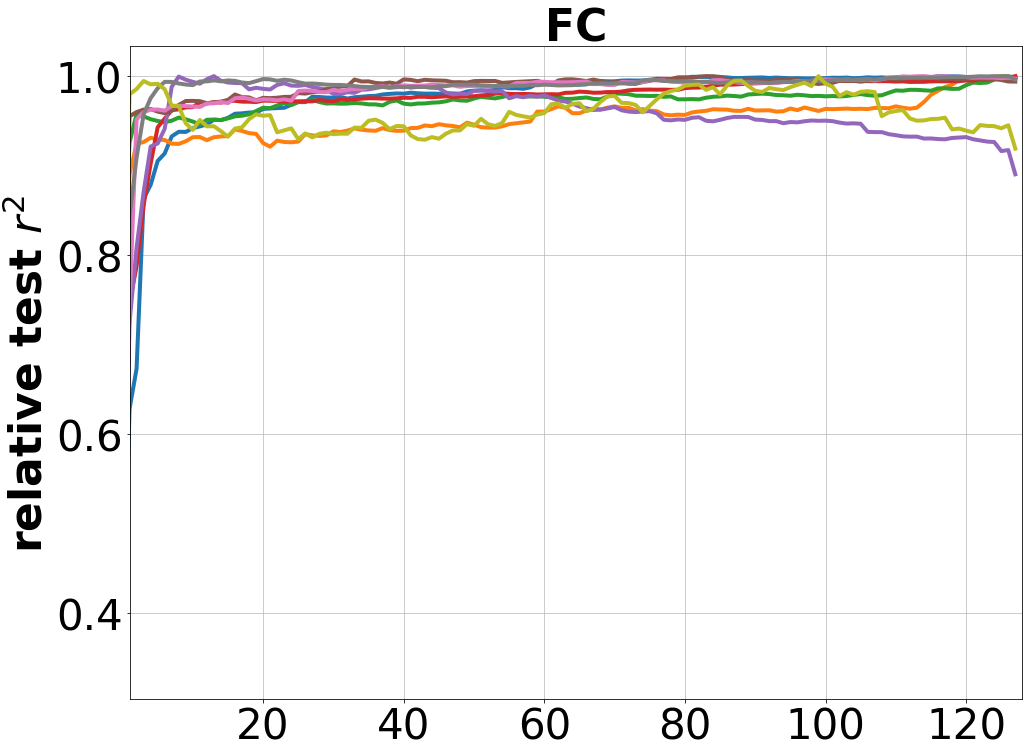

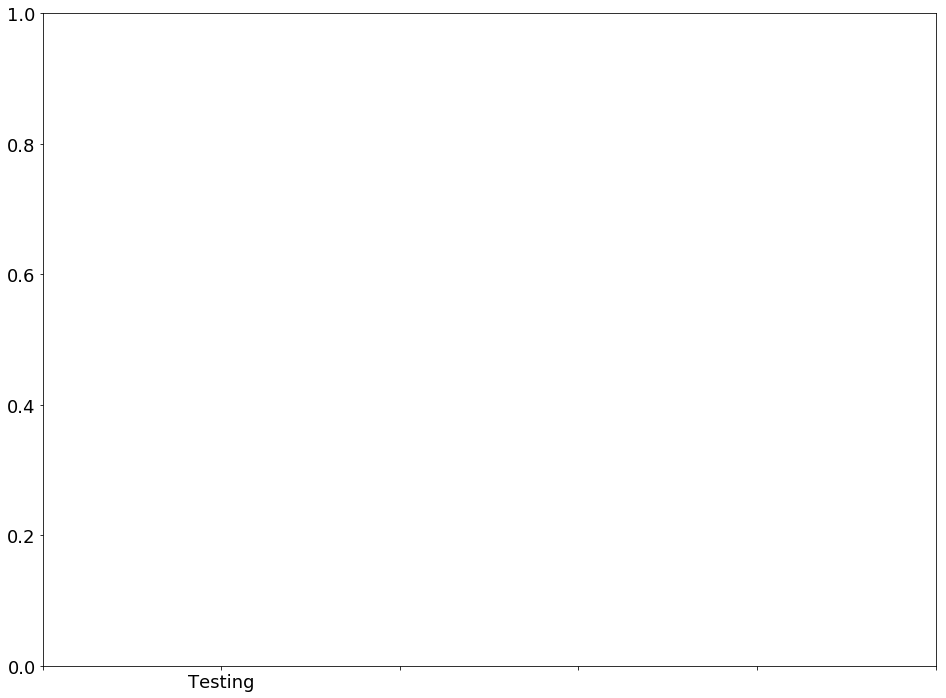

In [17]:
celltype = 'complex'
metric = 'r2'
lw = 4
#model_type = 'cnn'
colors = {'fc':'orange', 'cnn':'teal'}
metric_names = {'r2':'r^2', 'bps':'I_{ss}'}
if metric == 'r2': ylab = 'relative test $r^2$';
else: ylab = 'relative test $I_{ss}$';
    
#fig, ax = plt.subplots()
for model_type in ['fc']:
    path = './SavedResults/{}_{}_pca_{}.csv'.format(celltype, model_type, metric)
    p = np.genfromtxt(path, delimiter=',')

    # plot individual traces
    for i in range(1,cell_nums[celltype]+1):
        m = np.max(p[i-1,:])
        plt.plot(p[i-1,:]/m, label='{} {}'.format('cell',i), linewidth=lw)
        
#plt.xlabel('PCs', fontsize=44, fontweight='bold')
plt.xlim([1,p.shape[1]])
plt.ylabel(ylab, fontsize=44, fontweight='bold')
plt.title('{}'.format(model_type.upper()), fontsize=44, fontweight='bold')
plt.grid(alpha=0.8)
#plt.legend(loc='lower right', fontsize=26, framealpha=0.4)
plt.tick_params(axis='both', labelsize=42)
#plt.savefig('/Users/TedMoskovitz/Thesis/Figures/{}_{}_pca.pdf'.format(celltype, model_type))

fig, ax = plt.subplots()
#labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[1] = 'Testing'
#print (labels)
#ax.set_xticklabels(labels)
plt.show()

9


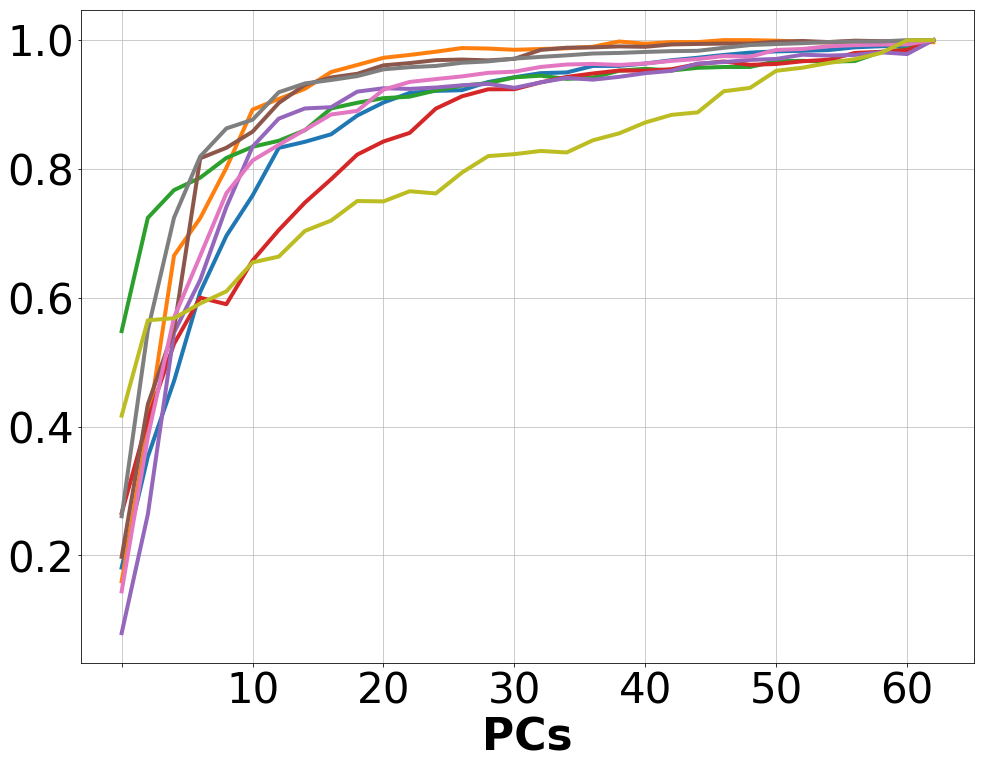

In [32]:
celltype = 'complex'
metric = 'r2'
lw = 4
#model_type = 'cnn'
colors = {'fc':'orange', 'cnn':'teal'}
metric_names = {'r2':'r^2', 'bps':'I_{ss}'}
if metric == 'r2': ylab = 'relative test $r^2$';
else: ylab = 'relative test $I_{ss}$';
    
fig, ax = plt.subplots()
for model_type in ['cnn']:
    path = './SavedResults/{}_{}_pca_{}.csv'.format(celltype, model_type, metric)
    p = np.genfromtxt(path, delimiter=',')

    # plot individual traces
    for i in range(1,cell_nums[celltype]+1):
        m = np.max(p[i-1,:])
        ax.plot(p[i-1,:]/m, label='{} {}'.format('cell',i), linewidth=lw)
        
plt.xlabel('PCs', fontsize=44, fontweight='bold')
#ax.set_xlim([1,p.shape[1]])
#ax.set_ylabel(ylab, fontsize=44, fontweight='bold')
#ax.set_title('{}'.format(model_type.upper()), fontsize=44, fontweight='bold')
ax.grid(alpha=0.8)
#plt.legend(loc='lower right', fontsize=26, framealpha=0.4)
ax.tick_params(axis='both', labelsize=42)
#plt.savefig('/Users/TedMoskovitz/Thesis/Figures/{}_{}_pca.pdf'.format(celltype, model_type))

#fig, ax = plt.subplots()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = ''
labels[2] = '10'
labels[3] = '20'
labels[4] = '30'
labels[5] = '40'
labels[6] = '50'
labels[7] = '60'
print (len(labels))
ax.set_xticklabels(labels)
plt.savefig('/Users/TedMoskovitz/Thesis/Figures/{}_{}_pca.pdf'.format(celltype, model_type))
plt.show()

8


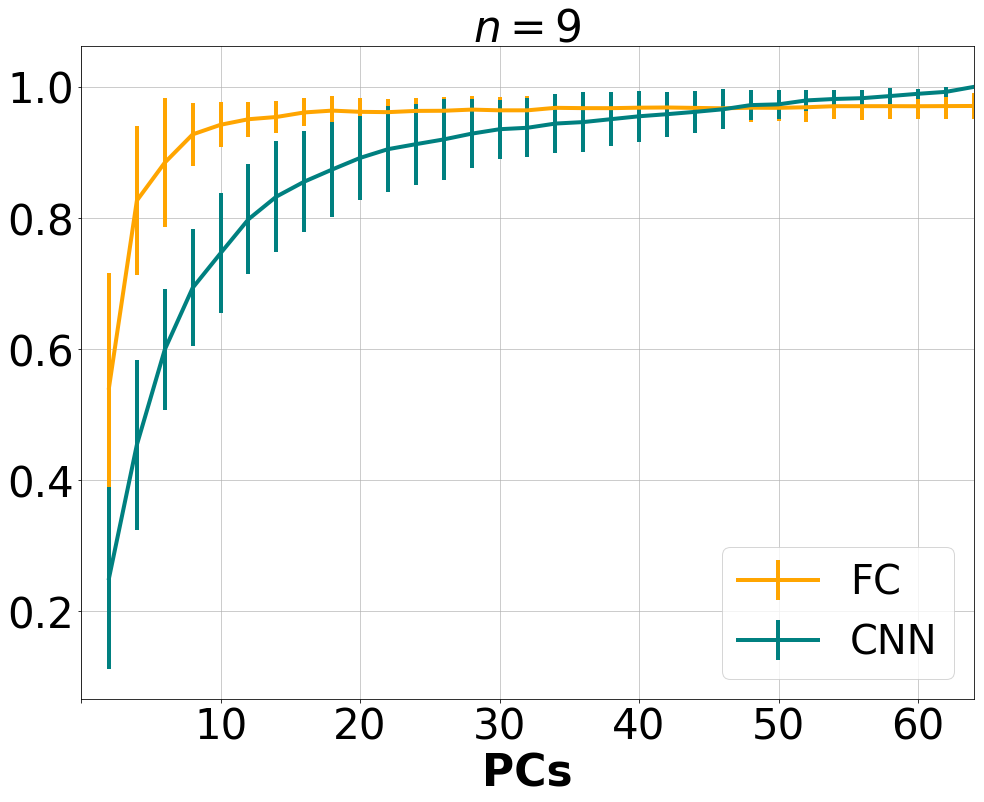

In [44]:
celltype = 'complex'
fig, ax = plt.subplots()
for model_type in ['fc', 'cnn']:
    path = './SavedResults/{}_{}_pca_{}.csv'.format(celltype, model_type, metric)
    p = np.genfromtxt(path, delimiter=',')
    # plot average traces
    p_norm = np.zeros_like(p)
    for r in range(cell_nums[celltype]):
        m = np.max(p[r,:])
        p_norm[r,:] = p[r,:] / m

    n = p.shape[1]
    xs = np.arange(n)+1
    ax.errorbar(xs[:], np.mean(p_norm[:,:], axis=0), yerr=np.std(p_norm[:,:], axis=0),
                 color=colors[model_type], label=model_type.upper(), linewidth=lw)
ax.set_xlabel('PCs', fontsize=44, fontweight='bold')
#plt.ylabel(ylab, fontsize=44)
ax.set_xlim([0,p.shape[1]])
plt.title('$n=9$'.format(celltype), fontsize=44, fontweight='bold')
ax.grid(alpha=0.8)
plt.legend(loc='lower right', fontsize=40)
#plt.ylim([0.65, 1.04])
ax.tick_params(axis='both', labelsize=42)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = '10'
labels[2] = '20'
labels[3] = '30'
labels[4] = '40'
labels[5] = '50'
labels[6] = '60'
#labels[7] = '60'
print (len(labels))
ax.set_xticklabels(labels)

plt.savefig('/Users/TedMoskovitz/Thesis/Figures/{}_avg_pca.pdf'.format(celltype))
plt.show()

In [42]:
celltype = 'complex'
m = get_nn_model(celltype, 'fc', metric='r2', verbose=True, filts=False)
m.summary()

loading fc...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_350 (Dense)            (None, 128)               32896     
_________________________________________________________________
activation_252 (Activation)  (None, 128)               0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_351 (Dense)            (None, 1)                 129       
Total params: 33,025
Trainable params: 33,025
Non-trainable params: 0
_________________________________________________________________


In [171]:
print (np.sqrt(np.sum((filts-m.layers[0].get_weights()[0])**2)))

0.0


In [177]:
filts = m.layers[0].get_weights()[0]

In [178]:
fs = m.layers[0].get_weights()
m.layers[0].set_weights(weights=[filts, fs[1]])

In [17]:
m.summary()

_, rsq = r2(m.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
__________

In [18]:
rsq

0.0078475506570980531

**DNN-LNP Hybrid Architecture**

hyperparameter settings

In [102]:
#ln_fs = [2,4,8,12,16,24]
#ln_fs = [1,2,4,8,16,32]
ln_fs = [7] #1,2,3,4,5,6,

#s_fc_config = {'L':2, 'H':50}
s_fc_config = {'L':1, 'H':64}
s_rnn_config = {'L':2, 'H':50}
s_cnn_config = {'L':0, 'H':64}

c_fc_config = {'L':2, 'H':128}
c_rnn_config = {'L':2, 'H':25}
c_cnn_config = {'L':1, 'H':32}


params = {'fc':{'simple':s_fc_config, 'complex':c_fc_config},
          'rnn':{'simple':s_rnn_config, 'complex':c_rnn_config},
          'cnn':{'simple':s_cnn_config, 'complex':c_cnn_config}}

training pipeline

In [113]:
celltype = 'complex'
model_type = 'fc'
plot = False 
gen_psth = False
save_model = False
save_perf = False
restore_frm_chkpt = False
v1 = V1(celltype, 1)

nfilts = len(ln_fs)
use_filts = False
trainable = True # freeze/un-freeze pre-trained filters


pf_bps = np.zeros([nfilts, cell_nums[celltype]])
pf_r2 = np.zeros([nfilts, cell_nums[celltype]])
best_r2 = -1.
best_bps = -1.


# for saving
prefix = ''
if use_filts: prefix += 'istac_';
else: prefix += 'filts_'
if trainable: prefix += 'tr_';
    
print (prefix)


if restore_frm_chkpt:
    print (color.BOLD + 'loading checkpoint...' + color.END)
    pf_bps = restore_performance_checkpt('./SavedResults/' + prefix + celltype \
                                                  + '_' + model_type + '_bps.csv')
    pf_bps = pf_bps.reshape(-1, cell_nums[celltype])
    best_bps = np.max(pf_bps)
    
    pf_r2 = restore_performance_checkpt('./SavedResults/' + prefix + celltype \
                                                 + '_' + model_type + '_r2.csv')
    pf_r2 = pf_r2.reshape(-1, cell_nums[celltype])
    best_r2 = np.max(pf_r2)
    
    
# define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=3, min_delta=.1, verbose=1, mode='auto')
callbacks_list = [earlystop]

# model type
gen_model = {'fc':gen_fc_model, 'rnn':gen_rnn_model, 'cnn':gen_cnn_model}

# data format
if model_type in ['rnn', 'cnn']: flatten = False;
else: flatten = True;

H = params[model_type][celltype]['H']
L = params[model_type][celltype]['L']

cell_r2s = []



j = 0
for cell_num in [3]:#range(cell_nums[celltype]):
    v1 = V1(celltype, cell_num+1, flatten=flatten);
    filters = None if not use_filts else np.genfromtxt('./SavedFilters/'+celltype+'_istac_filters_cell'+str(cell_num+1)+'.csv',
                                                       delimiter=',')
    i = 0
    #best_r2 = -1.
    for nf in ln_fs:
        if pf_bps[i,j] == 0.:
            print ("============================================================")
            print (color.BOLD + "Training Model on Cell " + str(cell_num+1) + " of " + str(cell_nums[celltype])  \
                   + " with " + str(nf) + " Filter(s)" + color.END) 
            
            # if initializing with pre-trained/calculated filters (i.e. iSTAC)
            if filters is not None: filts = filters[:,:nf];
            else: filts = None;
            print (filts is None)
            model = gen_model[model_type](H, L=L, LNP=nf, dim=v1.X_train.shape[-1], filts=filts, trainable=trainable)

            hist = model.fit(v1.X_train, v1.y_train, batch_size=50, epochs=35,
                             verbose=1, callbacks=None, validation_data=(v1.X_val, v1.y_val)) 
            time.sleep(0.1)

            # evaluate performance metrics
            bps,_ = get_bps(model, v1)
            _, rsq = r2(model.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,))
            
            # save best-performing model
            if bps > best_bps and save_model:
                best_bps = bps
                print (color.PURPLE + 'saving new bps model...' + color.END)
                model.save('SavedModels/' + prefix + celltype + '_best_' + model_type + '_bps.h5') 

            if rsq > best_r2 and save_model:
                best_r2 = rsq
                print (color.PURPLE + 'saving new r2 model...' + color.END)
                model.save('SavedModels/' + prefix + celltype + '_best_' + model_type + '_r2.h5')

            pf_bps[i,j] = bps
            pf_r2[i,j] = rsq

            if gen_psth:
                rpt_preds = model.predict(v1.X_rpt)
                model_psth = v1.convert_nn_psth(rpt_preds)

                if plot:
                    plt.plot(model_psth, label='nn')
                    plt.plot(v1.psth, label='repeat')
                    plt.legend()
                    plt.xlabel('Time (ms)')
                    plt.ylabel('Rate (sp/s)')
                    plt.show()


            print ("bps: ", bps)
            print ("r2: ", rsq)
            print (" ")


        i += 1

        if save_perf:
            print (color.BOLD + 'saving performance checkpoint...\n' + color.END)
            np.savetxt('./SavedResults/' + prefix + celltype + '_' + model_type \
                       + '_bps.csv', pf_bps.reshape(-1,1), delimiter=',')
            np.savetxt('./SavedResults/' + prefix + celltype + '_' + model_type \
                       + '_r2.csv', pf_r2.reshape(-1,1), delimiter=',')

    j += 1
    cell_r2s.append(best_r2)
    

building data...
fetching repeat data...
done.
filts_tr_
building data...
fetching repeat data...
done.
Training Model on Cell 4 of 9 with 7 Filter(s)
True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_149 (Dense)            (None, 7)                 1799      
_________________________________________________________________
dense_150 (Dense)            (None, 128)               1024      
_________________________________________________________________
activation_10 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_151 (Dense)            (None, 128)               16512     
_________________________________________________________________
activation_11 (Activation)   (None, 128)            

In [6]:
.024

0.2895

In [20]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())

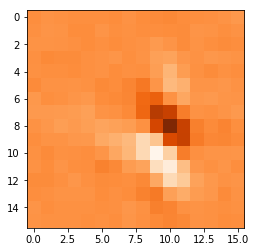

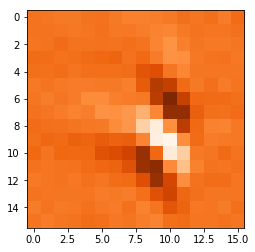

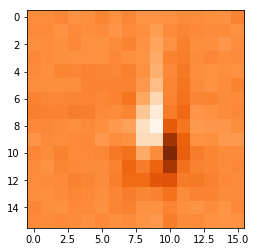

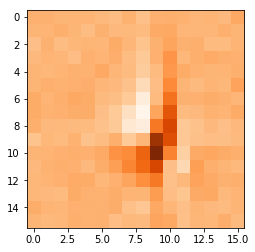

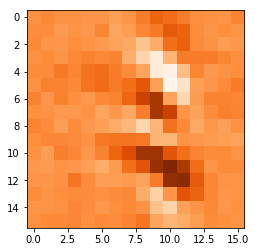

In [21]:
for i in range(5):
    w = weights[0][0][:,i].reshape(16,16)
    w /= np.linalg.norm(w)
    plt.imshow(w, interpolation='nearest', cmap='Oranges')
    plt.show()

comparison of convergence rates

In [42]:
np.savetxt('./SavedResults/simple_fc_bps_loss.csv', hist.history['loss'], delimiter=',')

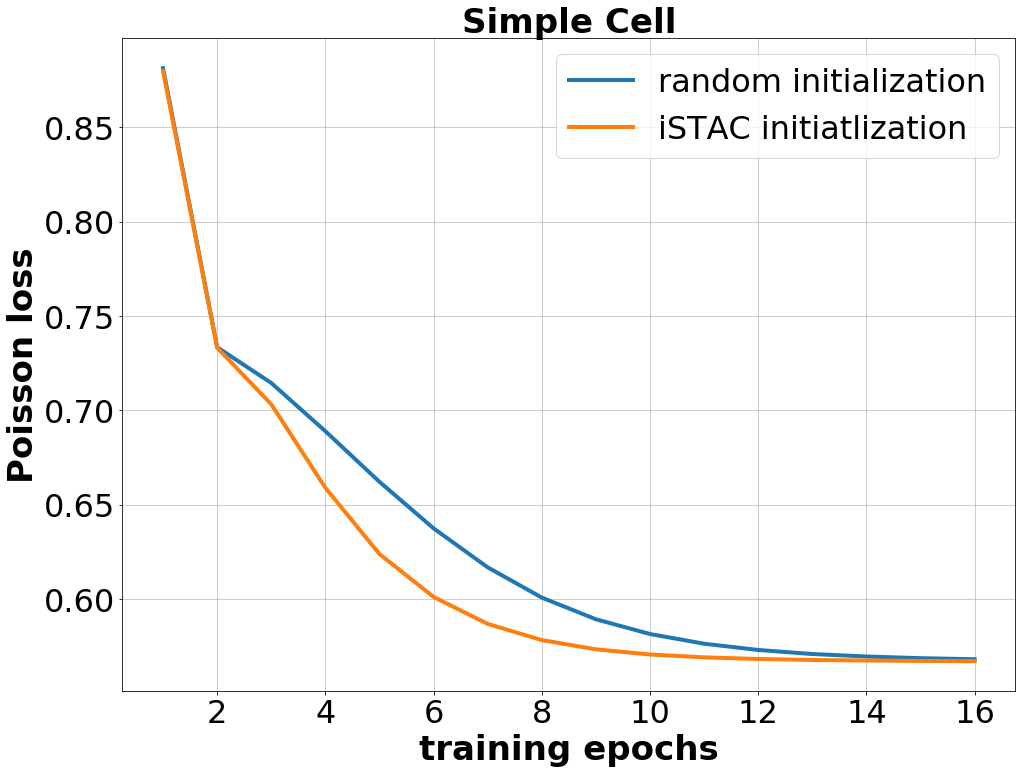

In [51]:
celltype = 'simple'
#h1 = np.genfromtxt('./SavedResults/filts_simple_fc_bps_loss.csv', delimiter=',')
#h2 = np.genfromtxt('./SavedResults/istac_tr_simple_fc_bps_loss.csv', delimiter=',')
#h3 = np.genfromtxt('./SavedResults/simple_fc_bps_loss.csv', delimiter=',')
h1 = np.genfromtxt('./SavedResults/filts_{}_bps_loss.csv'.format(celltype), delimiter=',')
h2 = np.genfromtxt('./SavedResults/istac_tr_{}_bps_loss.csv'.format(celltype), delimiter=',')
n_epochs = len(h2)
epochs = np.arange(n_epochs) + 1
plt.plot(epochs, h1, label='random initialization', linewidth=4)
plt.plot(epochs, h2, label='iSTAC initiatlization', linewidth=4)
plt.title('{} Cell'.format(celltype[0].upper() + celltype[1:]), fontsize=34, fontweight='bold')
#plt.plot(h3, label='DNN')
plt.legend(fontsize=32)
plt.xlabel('training epochs', fontsize=34, fontweight='bold')
plt.ylabel('Poisson loss', fontsize=34, fontweight='bold')
plt.grid(alpha=0.8)
#plt.xticks([5,10,15,20,25,30,35])
plt.tick_params(labelsize=32)
#plt.ylim([0.56, 0.89]) # simple
plt.savefig('/Users/TedMoskovitz/Desktop/{}_istac_loss1.pdf'.format(celltype))
plt.show()

In [54]:
weights = [l.get_weights() for l in model.layers]

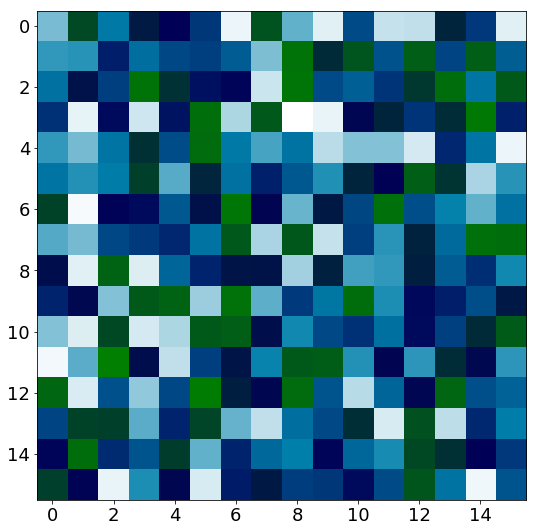

IndexError: index 1 is out of bounds for axis 1 with size 1

In [55]:
weights = [l.get_weights() for l in model.layers]
for i in range(4):
    plt.imshow(weights[0][0][:,i].reshape(-1,16), interpolation='nearest', cmap='ocean')
    plt.show()

In [4]:
x,y,z = nl.generate(model)

18000 / 90000 points computed
36000 / 90000 points computed
54000 / 90000 points computed
72000 / 90000 points computed


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


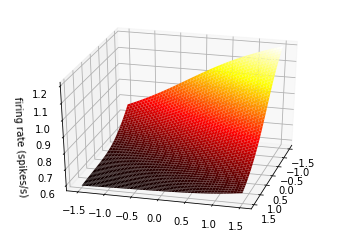

In [7]:
#from comp_nlin import comp_nlin2D
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal as spsig
import scipy.ndimage as spnd
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x, y, z, cmap='hot', alpha=1.0) #, label='NN'

#plt.show()

# rotate the axes and update
for angle in [15]:#range(0, 360):
    ax.view_init(30, angle)
    #ax.set_zlabel('firing rate (sp/s)')
    plt.draw()
    plt.pause(.001)

ax.legend()
ax.set_zlabel('firing rate (spikes/s)')
plt.show()



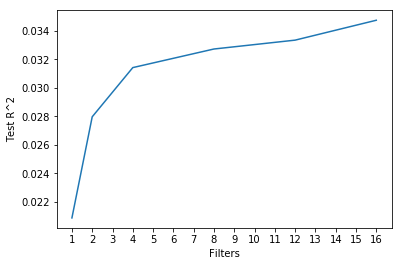

In [9]:
plt.plot(ln_fs, np.mean(pf_r2, axis=1))
plt.xlabel('Filters')
plt.ylabel('Test R^2')
plt.xticks(np.asarray(range(max(ln_fs)))+1)
plt.show()

In [188]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())
    
print len(weights)

5


In [3]:
cell = 'simple'
model = 'cnn'
metric = 'r2'

model = get_nn_model(cell, model, metric=metric, filts=False)
model.summary()

loading cnn...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_183 (Conv1D)          (None, 16, 64)            7232      
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 16, 64)            28736     
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 8, 64)             0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 8, 64)             20544     
_________________________________________________________________
conv1d_186 (Conv1D)          (None, 8, 64)             20544     
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 4, 64)             0     

In [7]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())

In [8]:
len(weights[0])

2

In [9]:
weights[0][1].shape

(5,)

In [7]:
mod = load_model('SavedModels/es_tr_simple_best_fc_r2.h5', custom_objects={'poiss_full': poiss_full})

In [8]:
mod.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stim (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
exc_filter (Dense)              (None, 3)            771         input_stim[0][0]                 
__________________________________________________________________________________________________
sup_filter (Dense)              (None, 2)            514         input_stim[0][0]                 
__________________________________________________________________________________________________
excitatory_wts (Dense)          (None, 3)            12          exc_filter[0][0]                 
__________________________________________________________________________________________________
suppressiv

In [14]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())

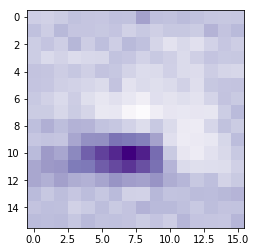

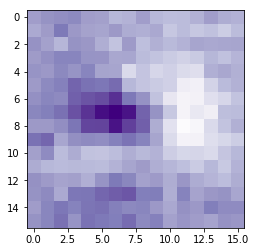

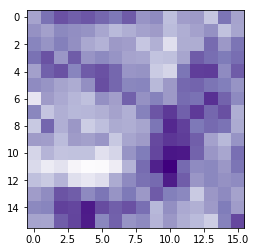

In [18]:
for i in range(3):
    w = weights[1][0][:,i].reshape(16,16)
    w /= np.linalg.norm(w)
    plt.imshow(w, interpolation='nearest', cmap='Purples')
    plt.show()

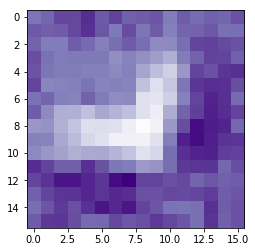

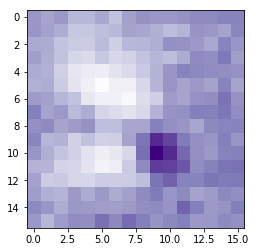

In [19]:
for i in range(2):
    w = weights[2][0][:,i].reshape(16,16)
    w /= np.linalg.norm(w)
    plt.imshow(w, interpolation='nearest', cmap='Purples')
    plt.show()

In [10]:
def normalize(f):
    mu = np.mean(f)
    var = np.var(f)
    eps = 1e-7
    return (f - mu) / np.sqrt(var + eps)

In [15]:
for i in range(5):
    filt = weights[0][0][:,i]
    print (np.max(weights[0][0][:,i]))
    print (np.min(weights[0][0][:,i]))
    if np.abs(np.max(filt)) >= np.abs(np.min(filt)): print ('Excitatory:');
    else: print ('Inhibitory:')
    w = weights[0][0][:,i].reshape(16,16)
    plt.imshow(w/np.linalg.norm(w), interpolation='nearest', cmap='bone')
    #plt.imshow(normalize(filt).reshape(16,16), interpolation='nearest', cmap='hot')
    plt.colorbar()
    plt.show()

IndexError: list index out of range

In [4]:
E = np.hstack([weights[0][0][:,i].reshape(-1,1) for i in [0,1,3]])
print (E.shape)
S = np.hstack([weights[0][0][:,i].reshape(-1,1) for i in [2,4]])
H = 32

(256, 3)


In [5]:
es_model = gen_ES_model(E, S, H, dim=256, L=2, verbose=True)

In [6]:
es_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stim (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
exc_linear (Dense)              (None, 3)            771         input_stim[0][0]                 
__________________________________________________________________________________________________
sup_linear (Dense)              (None, 2)            514         input_stim[0][0]                 
__________________________________________________________________________________________________
excitatory_filt (Dense)         (None, 3)            12          exc_linear[0][0]                 
__________________________________________________________________________________________________
suppressiv

**Excitatory-Suppressive Model** 

(inspired by Rust et al. '05)

In [20]:
def get_E_and_S(model, n_filts):
    """
    Extract excitatory and suppressive filters from a given model. 
    
    Args: 
        model: a trained Keras model
        
    Returns: 
        E: stacked excitatory filters (numpy ndarray)
        S: stacked suppressive filters (numpy ndarray)
    """
    weights = []
    for layer in model.layers:
        weights.append(layer.get_weights())
        
    filters = weights[0][0]
    filters = filters[:,:n_filts]
    
    # heuristic to ID E and S: E if max value > min, S if min > max
    Es = []
    Ss = []
    for i in range(filters.shape[1]):
        filt = filters[:,i]
        if np.abs(np.max(filt)) >= np.abs(np.min(filt)): Es.append(i);
        else: Ss.append(i);
    
    # if model lacks excitatory and/or suppressive filters
    if len(Es) > 0: E = np.hstack([filters[:,i].reshape(-1,1) for i in Es]);
    else: E = np.random.randn(filters.shape[0]).reshape(-1,1)
    if len(Ss) > 0: S = np.hstack([filters[:,i].reshape(-1,1) for i in Ss]);
    else: S = np.random.randn(filters.shape[0]).reshape(-1,1)
    
    return E,S

training pipeline

In [12]:
celltype = 'simple'
model_type = 'fc'
plot = False 
gen_psth = False
save_model = True
save_perf = True
restore_frm_chkpt = False
v1 = V1(celltype, 1)
use_istac = False

Ls = [0,1,2,3]
Hs = [16,32,96,128]
filters = [2,3,4,5,6,7]

pf_bps = np.zeros([len(Ls), len(Hs), cell_nums[celltype]])
pf_r2 = np.zeros([len(Ls), len(Hs), cell_nums[celltype]])
best_r2 = -1.
best_bps = -1.

if restore_frm_chkpt:
    print (color.BOLD + 'loading checkpoint...' + color.END)
    pf_bps = restore_performance_checkpt('./SavedResults/es_tr_' + celltype \
                                                  + '_' + model_type + '_bps.csv')
    pf_bps = pf_bps.reshape(len(Ls), len(Hs), -1)
    best_bps = np.max(pf_bps)
    
    pf_r2 = restore_performance_checkpt('./SavedResults/es_tr_' + celltype \
                                                 + '_' + model_type + '_r2.csv')
    pf_r2 = pf_r2.reshape(len(Ls), len(Hs), -1)
    best_r2 = np.max(pf_r2)
    
    
# define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=3, min_delta=.1, verbose=1, mode='auto')
callbacks_list = [earlystop]

# model type
gen_model = {'fc':gen_fc_model, 'rnn':gen_rnn_model, 'cnn':gen_cnn_model}

# data format
if model_type in ['rnn', 'cnn']: flatten = False;
else: flatten = True;

k = 0
for cell_num in range(cell_nums[celltype]):
    v1 = V1(celltype, cell_num+1, flatten=flatten)
    
    
    
    for nf in 
    if use_istac:
        pass
    else:
        # load model from which filters will be pulled
        filt_model = get_nn_model(celltype, model_type, metric='r2', filts=True, cell=cell_num+1)
        # extract filters
        E,S = get_E_and_S(filt_model, nf)
    
    if E is not None:
        i = 0
        for L in Ls:
            j = 0
            for H in Hs:
                if pf_bps[i,j,k] == 0.:
                    print ("============================================================")
                    print (color.BOLD + "Training Model on Cell " + str(cell_num+1) + " of " + str(cell_nums[celltype])  \
                           + " with depth of " + str(L) + " and width of " + str(H) + color.END) 
                    
                    # load model
                    model = gen_ES_model(E, S, H, dim=v1.X_train.shape[-1], L=L, verbose=True, trainable=True) 
                    
                    # fit model
                    hist = model.fit(v1.X_train, v1.y_train, batch_size=50, epochs=10+L*4,
                                     verbose=1, callbacks=None, validation_data=(v1.X_val, v1.y_val)) 
                    time.sleep(0.1)

                    # evaluate performance metrics
                    bps,_ = get_bps(model, v1)
                    _, rsq = r2(model.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,))

                    if bps > best_bps and save_model:
                        best_bps = bps
                        print (color.PURPLE + 'saving new bps model...' + color.END)
                        model.save('SavedModels/es_tr_' + celltype + '_best_' + model_type + '_bps.h5')

                    if rsq > best_r2 and save_model:
                        best_r2 = rsq
                        print (color.PURPLE + 'saving new r2 model...' + color.END)
                        model.save('SavedModels/es_tr_' + celltype + '_best_' + model_type + '_r2.h5')

                    pf_bps[i,j,k] = bps
                    pf_r2[i,j,k] = rsq

                    if gen_psth:
                        rpt_preds = model.predict(v1.X_rpt)
                        model_psth = v1.convert_nn_psth(rpt_preds)

                        if plot:
                            plt.plot(model_psth, label='nn')
                            plt.plot(v1.psth, label='repeat')
                            plt.legend()
                            plt.xlabel('Time (ms)')
                            plt.ylabel('Rate (sp/s)')
                            plt.show()


                    print ("bps: ", bps)
                    print ("r2: ", rsq)
                    print (" ")


                j += 1

                if save_perf: 
                    print (color.BOLD + 'saving checkpoint...\n' + color.END)
                    np.savetxt('./SavedResults/es_tr_' + celltype + '_' + model_type \
                               + '_bps.csv', pf_bps.reshape(-1,1), delimiter=',')
                    np.savetxt('./SavedResults/es_tr_' + celltype + '_' + model_type \
                               + '_r2.csv', pf_r2.reshape(-1,1), delimiter=',')
            i += 1
        k += 1



building data...
fetching repeat data...
done.
loading checkpoint...
building data...
fetching repeat data...
done.
loading fc...
saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

building data...
fetching repeat data...
done.
loading fc...
building data...
fetching repeat data...
done.
loading fc...
Training Model on Cell 3 of 3 with depth of 0 and width of 16
Train on 68801 samples, validate on 9828 samples
Epoch 1/10
68801/68801 [==============================] - 4s 51us/step - loss: 0.8051 - val_loss: 0.7730
Epoch 2/10
68801/68801 [==============================] - 2s 30us/step - loss: 0.7259 - val_loss: 0.7196
Epoch 3/10
68801/68801 [==============================] - 2s 29us/step - lo

68801/68801 [==============================] - 3s 40us/step - loss: 0.6396 - val_loss: 0.6485
Epoch 5/14
68801/68801 [==============================] - 3s 42us/step - loss: 0.6326 - val_loss: 0.6428
Epoch 6/14
68801/68801 [==============================] - 3s 44us/step - loss: 0.6266 - val_loss: 0.6378
Epoch 7/14
68801/68801 [==============================] - 3s 43us/step - loss: 0.6217 - val_loss: 0.6335
Epoch 8/14
68801/68801 [==============================] - 3s 40us/step - loss: 0.6178 - val_loss: 0.6303
Epoch 9/14
68801/68801 [==============================] - 3s 42us/step - loss: 0.6145 - val_loss: 0.6273
Epoch 10/14
68801/68801 [==============================] - 3s 39us/step - loss: 0.6121 - val_loss: 0.6252
Epoch 11/14
68801/68801 [==============================] - 3s 42us/step - loss: 0.6101 - val_loss: 0.6234
Epoch 12/14
68801/68801 [==============================] - 3s 42us/step - loss: 0.6087 - val_loss: 0.6225
Epoch 13/14
68801/68801 [==============================] - 3s 4

68801/68801 [==============================] - 3s 38us/step - loss: 0.6422 - val_loss: 0.6522
Epoch 5/22
68801/68801 [==============================] - 3s 40us/step - loss: 0.6365 - val_loss: 0.6465
Epoch 6/22
68801/68801 [==============================] - 3s 38us/step - loss: 0.6311 - val_loss: 0.6419
Epoch 7/22
68801/68801 [==============================] - 3s 38us/step - loss: 0.6262 - val_loss: 0.6377
Epoch 8/22
68801/68801 [==============================] - 3s 38us/step - loss: 0.6218 - val_loss: 0.6334
Epoch 9/22
68801/68801 [==============================] - 3s 39us/step - loss: 0.6178 - val_loss: 0.6315
Epoch 10/22
68801/68801 [==============================] - 3s 40us/step - loss: 0.6142 - val_loss: 0.6281
Epoch 11/22
68801/68801 [==============================] - 3s 38us/step - loss: 0.6115 - val_loss: 0.6253
Epoch 12/22
68801/68801 [==============================] - 3s 38us/step - loss: 0.6093 - val_loss: 0.6232
Epoch 13/22
68801/68801 [==============================] - 3s 3

In [10]:
def get_E_and_S_filt(filters, cell_num, cell_type):
    """
    Extract excitatory and suppressive filters from a given model. 
    
    Args: 
        filts: filters
        cell_num: which cell in the population
        cell_type: cell type
        
    Returns: 
        E: stacked excitatory filters (numpy ndarray)
        S: stacked suppressive filters (numpy ndarray)
    """
    # heuristic to ID E and S: E if max value > min, S if min > max
    Es = []
    Ss = []
    sta = np.genfromtxt('SavedFilters/{}_sta_cell{}.csv'.format(cell_type, cell_num), delimiter=',')
    sta = sta.reshape(-1,1)
    stc = np.genfromtxt('SavedFilters/{}_stc_cell{}.csv'.format(cell_type, cell_num), delimiter=',')
    S, V = np.linalg.eig(stc)
    med_eig = np.median(S)
    '''
    for i in range(filters.shape[1]):
        filt = filters[:,i]
        if np.abs(np.max(filt)) >= np.abs(np.min(filt)): Es.append(i);
        else: Ss.append(i);
    '''
    for i in range(filters.shape[1]):
        filt = filters[:,i].reshape(-1,1)
        response_val = np.dot(np.dot(filt.T, stc), filt)[0,0]
        if response_val > med_eig: Es.append(i);
        else: Ss.append(i);
            
        
    # if model lacks excitatory and/or suppressive filters; STA is always E
    if len(Es) > 0: E = np.hstack([sta] + [filters[:,i].reshape(-1,1) for i in Es]);
    else: E = sta
    if len(Ss) > 0: S = np.hstack([filters[:,i].reshape(-1,1) for i in Ss]);
    else: S = np.random.randn(filters.shape[0]).reshape(-1,1)
    
    return E,S

In [20]:
celltype = 'simple'
model_type = 'fc'
plot = False 
gen_psth = False
save_model = True
save_perf = True
restore_frm_chkpt = False
v1 = V1(celltype, 1)
use_istac = True
train_filts = False

Ls = [3]
Hs = [16] # 32 for complex
filters = [7]
n_filts = len(filters)

pf_bps = np.zeros([len(filters), cell_nums[celltype]])
pf_r2 = np.zeros([len(filters), cell_nums[celltype]])
best_r2 = -1.
best_bps = -1.

if restore_frm_chkpt:
    print (color.BOLD + 'loading checkpoint...' + color.END)
    pf_bps = restore_performance_checkpt('./SavedResults/es_tr_' + celltype \
                                                  + '_' + model_type + '_bps.csv')
    pf_bps = pf_bps.reshape(n_filts, -1)
    best_bps = np.max(pf_bps)
    
    pf_r2 = restore_performance_checkpt('./SavedResults/es_tr_' + celltype \
                                                 + '_' + model_type + '_r2.csv')
    pf_r2 = pf_r2.reshape(n_filts, -1)
    best_r2 = np.max(pf_r2)
    

# data format
flatten = True

j = 0
i = 0
for cell_num in range(cell_nums[celltype]):
    v1 = V1(celltype, cell_num+1, flatten=flatten)
    i = 0
    for nf in filters:
        #if pf_bps[i,j] == 0.0:
        
        # get iSTAC filters
        filts = np.genfromtxt('SavedFilters/'+ celltype+'_istac_filters_cell'+str(cell_num+1)+'.csv', delimiter=',')
        filts = filts[:,:nf]
        E,S = get_E_and_S_filt(filts, cell_num+1, celltype)

        best_filt_bps = -1
        best_filt_r2 = -1


        for L in Ls:
            for H in Hs:
                print ("============================================================")
                print (color.BOLD + "Training " + str(nf) + " Filter Model on Cell " + str(cell_num+1) + " of " + str(cell_nums[celltype])  \
                       + " with depth of " + str(L) + " and width of " + str(H) + color.END) 

                # load model
                model = gen_ES_model(E, S, H, dim=v1.X_train.shape[-1], L=L, lr=0.00005,
                                     verbose=True, trainable=train_filts) 
                model.summary()

                # fit model
                hist = model.fit(v1.X_train, v1.y_train, batch_size=50, epochs=20,
                                 verbose=1, callbacks=None, validation_data=(v1.X_val, v1.y_val)) 
                time.sleep(0.1)

                # evaluate performance metrics
                bps,_ = get_bps(model, v1)
                _, rsq = r2(model.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,))

                if bps > best_filt_bps: best_filt_bps = bps; 
                if rsq > best_filt_r2: best_filt_r2 = rsq; 

                if save_model: #bps > best_bps and
                    #best_bps = bps
                    print (color.PURPLE + 'saving new model...' + color.END)
                    model.save('SavedModels/real_es_' + celltype + '_' + model_type + '_cell' + str(cell_num+1) +'.h5')
                '''
                if rsq > best_r2 and save_model:
                    best_r2 = rsq
                    print (color.PURPLE + 'saving new r2 model...' + color.END)
                    model.save('SavedModels/real_es_tr_' + celltype + '_best_' + model_type + '_r2.h5')
                '''
                print ("bps: ", bps)
                print ("r2: ", rsq)
                print (" ")


        pf_bps[i,j] = best_filt_bps
        pf_r2[i,j] = best_filt_r2
        if save_perf: 
            print (color.BOLD + 'saving checkpoint...\n' + color.END)
            np.savetxt('./SavedResults/real_es_' + celltype + '_' + model_type \
                       + '_bps.csv', pf_bps, delimiter=',')
            np.savetxt('./SavedResults/real_es_' + celltype + '_' + model_type \
                       + '_r2.csv', pf_r2, delimiter=',')
        i += 1
    print (pf_r2)
    j += 1




building data...
fetching repeat data...
done.
building data...
fetching repeat data...
done.
Training 7 Filter Model on Cell 1 of 3 with depth of 3 and width of 16
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stim (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
exc_filter (Dense)              (None, 2)            514         input_stim[0][0]                 
__________________________________________________________________________________________________
sup_filter (Dense)              (None, 6)            1542        input_stim[0][0]                 
__________________________________________________________________________________________________
excitatory_wts (Dense)          (None, 2)  

Train on 229364 samples, validate on 32766 samples
Epoch 1/20
229364/229364 [==============================] - 14s 62us/step - loss: 0.4522 - val_loss: 0.4297
Epoch 2/20
229364/229364 [==============================] - 13s 57us/step - loss: 0.4281 - val_loss: 0.4277
Epoch 3/20
229364/229364 [==============================] - 14s 59us/step - loss: 0.4267 - val_loss: 0.4262
Epoch 4/20
229364/229364 [==============================] - 12s 53us/step - loss: 0.4247 - val_loss: 0.4234
Epoch 5/20
229364/229364 [==============================] - 12s 51us/step - loss: 0.4211 - val_loss: 0.4186
Epoch 6/20
229364/229364 [==============================] - 12s 52us/step - loss: 0.4158 - val_loss: 0.4129
Epoch 7/20
229364/229364 [==============================] - 12s 51us/step - loss: 0.4103 - val_loss: 0.4079
Epoch 8/20
229364/229364 [==============================] - 12s 51us/step - loss: 0.4059 - val_loss: 0.4043
Epoch 9/20
229364/229364 [==============================] - 12s 54us/step - loss: 0.4

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stim (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
exc_filter (Dense)              (None, 1)            257         input_stim[0][0]                 
__________________________________________________________________________________________________
sup_filter (Dense)              (None, 1)            257         input_stim[0][0]                 
__________________________________________________________________________________________________
excitatory_wts (Dense)          (None, 1)            2           exc_filter[0][0]                 
__________________________________________________________________________________________________
suppressiv

In [13]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())

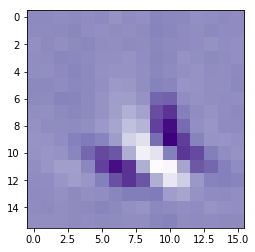

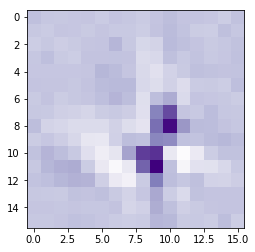

In [15]:
for i in range(2):
    w = weights[1][0][:,i].reshape(16,16)
    plt.imshow(w/np.linalg.norm(w), interpolation='nearest', cmap='Purples')
    plt.show()

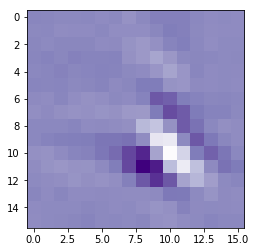

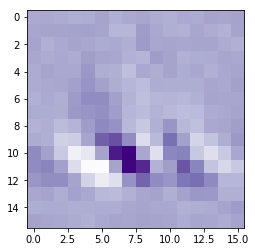

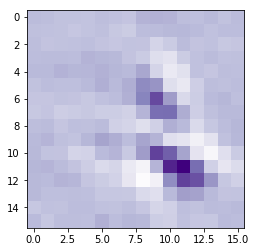

In [16]:
for i in range(3):
    w = weights[2][0][:,i].reshape(16,16)
    plt.imshow(w/np.linalg.norm(w), interpolation='nearest', cmap='Purples')
    plt.show()

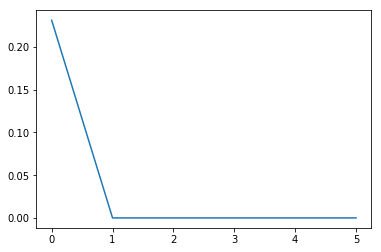

In [10]:
plt.plot(np.mean(pf_bps, axis=1))
plt.show()